# Simulação Modelo de Ising pelo Algoritmo de Metropolis
Arthur Souto Lima - 2018055113

## Imports e Funções Auxiliares

Imports de funções das bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numba import jit

Importar funções auxiliares usadas em atividades anteriores para auxiliar nas computações.

In [2]:
from wang import (energy_ising, # calcula a energia da rede na configuração atual
                  neighbours,   # computa a matriz de vizinhança da rede
                  random_energy_state # cria uma configuração aleatória
                 )

In [3]:
from metropolis import metropolis   # simula modelo de Ising via Metropolis, 
                                    # com pequenas alterações com relação à atividade anterior

A função do algoritmo de Metropolis usado anteriormente foi levemente modificado para que possamos obter também o estado final naquela temperatura e usá-lo como inicial da temperatura seguinte, como orientado no enunciado.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Processamento das Caixas (Bins) 

Obtidos os valores de energia e de magnetização, temos que separá-los em caixas (bins) e computar os valores necessários. Como pedido, o "primeiro bin" é descartado para fins de termalização.

In [4]:
def metropolis_bins(Energs, Mags, 
                    bin_size=10**5, 
                    total_mcs=1.1*10**6):
    """
    Obtém valores esperados simples e ao quadrado da energia e da magnetização
    da simulação do Modelo de Ising via Metropolis dentro de cada bin
    
    Parâmetros:
        Energs: array com as energias
        Mags: array com o módulo das magnetizações
        bin_size: tamanho da caixa, default 10**5
        total_mcs: quantidade total de passos de Monte Carlo, default 1.1e6
    
    Retornos:
        E : valor esperado de energia por bin
        E2: valor esperado de energia ao quadrado por bin
        M : valor esperado da magnetização por bin
        M2: valor esperado da magnetização ao quadrado por bin
    """
    # m: qtd de elementos por bin
    m = int(total_mcs / bin_size)
    
    # Descartar os primeiros 10**5, para fins de termalização
    Energs = Energs[bin_size:]
    Mags = Mags[bin_size:]
    assert(len(Energs) == (m-1)*bin_size)
    assert(len(Mags) == (m-1)*bin_size)
    m = m-1
    
    E = []  # Para guardar os E_j's
    E2 = []  # Para guardar os E^2_j's
    M = []  # Para guardar os M_j's
    M2 = []  # Para guardar os M^2_j's
    
    factor = 1/m
    for i in range(m):
        intervalE = np.array(Energs[i*m:(i+1)*m])
        intervalE2 = intervalE**2
        intervalM = np.array(Mags[i*m:(i+1)*m])
        intervalM2 = intervalM**2
              
        E.append(np.sum(factor * intervalE))
        E2.append(np.sum(factor * intervalE2))
        M.append(np.sum(factor * intervalM))
        M2.append(np.sum(factor * intervalM2))
        
    return E, E2, M, M2

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Propriedades Termodinâmicas

A seguir, são apresentados os algoritmos para computar os valores esperados e os erros associados a cada uma das grandezas pedidas no enunciado. São elas: calor específico, energia por spin, magnetização por spin e suscetibilidade magnética. 

#### Erro Estatístico Associado

O erro estatístico é sempre calculado da mesma forma, o que possibilita uma função genérica para tanto.

In [5]:
def error(ve, values):
    """
    Calcula o erro estatístico associado a uma grandeza.
    
    Parâmetros:
        ve: valor esperado da grandeza
        values: array com os valores da grandeza obtidos
    Retornos:
        err: erro estatístico associado
    """
    acc = 0
    n_bins = len(values)
    for i in range(n_bins):
        acc += (ve - values[i])**2
    err = np.sqrt(acc/(n_bins*(n_bins-1)))
    return err

#### Calor Específico

In [6]:
def media_calor(E, E2, beta, N):
    """
    Computa o valor esperado do calor específico 
    e seu erro estatístico associado
    
    Parâmetros:
        E : valor esperado de energia por bin
        E2: valor esperado de energia ao quadrado por bin
        beta: inverso da temperatura (1/T)
        N: quantidade de sítios da rede (N=LxL)
    
    Retornos:
        ve_cv: valor esperado do calor específico
        err: erro estatístico associado
    """
    # Cálculo do valor esperado
    n_bins = len(E)
    cv = np.zeros(n_bins)
    factor = beta**2/N
    for i in range(n_bins):
        term = E2[i] - E[i]**2
        term = factor * term
        cv[i] = term
    ve_cv = np.sum(cv)/n_bins
    
    # Cálculo do erro
    err = error(ve_cv, cv)
    
    return ve_cv, err

<br>
<br>
<br>
<br>
<br>
<br>
<br>

#### Energia por Spin

In [7]:
def media_energia_spin(E, E2, N):
    """
    Computa o valor esperado da energia por spin 
    e seu erro estatístico associado
    
    Parâmetros:
        E : valor esperado de energia por bin
        E2: valor esperado de energia ao quadrado por bin
        N: quantidade de sítios da rede (N=LxL)
    
    Retornos:
        ve_eps: valor esperado da energia por spin 
        err: erro estatístico associado
    """
    # Cálculo do valor esperado
    n_bins = len(E)
    EpS = np.zeros(n_bins)
    factor = 1/N
    for i in range(n_bins):
        EpS[i] = factor * E[i]
    ve_eps = np.sum(EpS)/n_bins
    
    # Cálculo do erro
    err = error(ve_eps, EpS)
    
    return ve_eps, err

#### Magnetização por Spin

In [8]:
def media_magn_spin(M, M2, N):
    """
    Computa o valor esperado do módulo da magnetização por spin 
    e seu erro estatístico associado
    
    Parâmetros:
        M : valor esperado de magnetização por bin
        M2: valor esperado de magnetização ao quadrado por bin
        N: quantidade de sítios da rede (N=LxL)
    
    Retornos:
        ve_mags: valor esperado da mangnetização por spin
        err: erro estatístico associado
    """
    # Cálculo do valor esperado
    n_bins = len(M)
    MagS = np.zeros(n_bins)
    factor = 1/N
    for i in range(n_bins):
        MagS[i] = factor * M[i]
    ve_mags = np.sum(MagS)/n_bins
    
    # Cálculo do erro
    err = error(ve_mags, MagS)
    
    return ve_mags, err

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

#### Susceptibilidade Magnética

In [9]:
def media_susceptibilidade(M, M2, beta, N):
    """
    Computa o valor esperado da susceptibilidade magnética
    e seu erro estatístico associado
    
    Parâmetros:
        M : valor esperado de magnetização por bin
        M2: valor esperado de magnetização ao quadrado por bin
        N: quantidade de sítios da rede (N=LxL)
    
    Retornos:
        ve_ssm: valor esperado da susceptibilidade magnética
        err: erro estatístico associado
    """
    # Cálculo do valor esperado
    n_bins = len(M)
    ssm = np.zeros(n_bins)
    factor = beta/N
    for i in range(n_bins):
        term = M2[i] - M[i]**2
        term = factor * term
        ssm[i] = term
    ve_ssm = np.sum(ssm)/n_bins
    
    # Cálculo do erro
    err = error(ve_ssm, ssm)
    
    return ve_ssm, err

## Estrutura de Dados para os Resultados

A fim de facilitar a leitura, entendimento e desenvolvimento, escolheu-se agrupar todas as informações de uma determinada rede numa única estrutura de dados. Assim, todos os dados referentes à ela ficam juntas.

In [10]:
class redeIsing2D:
    """
    Classe para agrupar todas as informações de uma determinada rede no modelo de Ising.
    Isso inclui seu tamanho e suas propriedades termodinâmicas
    """
    
    def __init__(self, L):
        """Inicializa rede e aloca vetores para dados termodinâmicos"""
        # Dimensões da rede
        self.L = L
        self.N = L**2
        
        # Estado anterior do sistema, para iterações seguintes
        self.s_anterior = None    
        
        # Propriedades termodinâmicas e seus erros associados
        self.temps = []
        self.cal, self.cal_err = [], []
        self.ener, self.ener_err = [], []
        self.mag, self.mag_err = [], []
        self.sus, self.sus_err = [], []
    
    def reverse_data(self):
        """Inverte os arrays de propriedades termodinâmicas"""
        self.temps.reverse()
        self.cal.reverse()
        self.cal_err.reverse()
        self.ener.reverse()
        self.ener_err.reverse()     
        self.mag.reverse()
        self.mag_err.reverse()
        self.sus.reverse()
        self.sus_err.reverse()

<br>
<br>
<br>

## Simulações

Utilizando os algoritmos apresentados anteriormente, pode-se fazer a simulação de redes 18x18, 24x24 e 36x36. Seguiremos as orientações dadas e iniciaremos a simulação da temperatura mais alta, ou seja, 5 partindo de uma configuração aleatória. A cada etapa, diminuiremos a temperatura em 0.25 e partiremos da última configuração anterior.

In [11]:
def prop_termo(r, E, E2, M, M2, temp, beta):
    """
    Calcula todas as propriedades termodinâmicas para a rede passada 
    na temperatura (e beta) informados.
    Os resultados são salvos na estrutura de dados da rede
    
    Parâmetros:
        r: a estrutura de dados que é a rede
        E : valor esperado de energia por bin
        E2: valor esperado de energia ao quadrado por bin
        M : valor esperado da magnetização por bin
        M2: valor esperado da magnetização ao quadrado por bin
        temp: temperatura do sistema
        beta: inverso da temperatura do sistema
    
    Retornos:
        Nenhum. O resultado é salvo na rede.
    """
    # Temperatura atual
    r.temps.append(temp)
    
    # Calor Específico
    cal, err = media_calor(E, E2, beta, r.N)
    r.cal.append(cal)
    r.cal_err.append(err)
    
    # Energia por Spin 
    energ, err = media_energia_spin(E, E2, r.N)
    r.ener.append(energ)
    r.ener_err.append(err)
    
    # Magnetização por Spin 
    mag, err = media_magn_spin(M, M2, r.N)
    r.mag.append(mag)
    r.mag_err.append(err)
    
    # Susceptibilidade Magnética 
    sus, err = media_susceptibilidade(M, M2, beta, r.N)
    r.sus.append(sus)
    r.sus_err.append(err)

In [12]:
def simulate(prints=False, fromScratch=False, file="redes_metropolis.dict"):
    """
    Cria e simula as redes 18x18, 24x24 e 36x36 via Algoritmo de Metropolis.
    Salva ou carrega essas simulações
    
    Parâmetros:
        prints: imprimir ou não progresso
        fromScratch: se verdadeiro, executa tudo do início e 
                     salva no arquivo. Se falso, apenas carrega do arquivo
        file: arquivo para salvar/carregar
        
    Retorno:
        redes: um array com as redes, nessa ordem 18x18, 24x24 e 36x36
    """
    # Criação das redes
    redes = [redeIsing2D(18), 
             redeIsing2D(24), 
             redeIsing2D(36)]
    
    if (fromScratch):
        # Simulação via Metropolis
        step = 0.25
        t_min = 1
        t_max = 5
        
        # Ir de 5 até 1, com passos de 0.25
        for temp in np.arange(t_max,t_min-step,-step):
            beta = 1/temp
            if (prints): print(f"{temp}: ", end ="", flush=True)

            for r in redes:
                # Simulação da rede via Metropolis nessa temperatura
                result = metropolis(L=r.L, s=r.s_anterior, 
                                    temp=temp, steps=1.1*10**6)
                Es, Mags, r.s_anterior = result

                # Processando as caixas
                E, E2, M, M2 = metropolis_bins(Es, Mags)

                # Cálculo das propriedades termodinâmicas
                prop_termo(r, E, E2, M, M2, temp, beta)
                if (prints): print(f"{r.L} ", end ="", flush=True)
            if (prints): print("", flush=True)
        
        # Salvar no arquivo
        with open(file, "wb") as f:
            pickle.dump(redes,f)
    else:
        # Carregar do arquivo
        with open(file, "rb") as f:
            redes = pickle.load(f)
    
    return redes

In [13]:
# redes = simulate(prints=True, fromScratch=True) # Se quiséssemos gerar novamente os dados
redes = simulate(prints=False, fromScratch=False)

Tendo em vista que os dados foram obtidos da maior para a menor temperatura, devemos inverter todos os arrays para termos melhores visualizações e ser possível fazer uma comparação mais direta com os resultados de atividades anteriores.

In [14]:
for r in redes:
    r.reverse_data()

<br>
<br>
<br>
<br>
<br>
<br>

## Resultados e Discussão

### Calor Específico

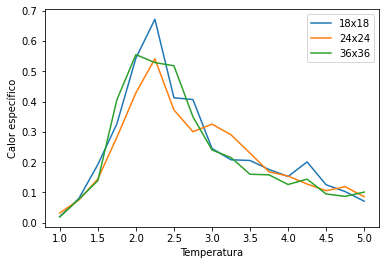

In [15]:
for r in redes: plt.plot(r.temps, r.cal)
plt.ylabel("Calor específico")
plt.xlabel("Temperatura")
plt.legend(["18x18","24x24","36x36"])
plt.show()

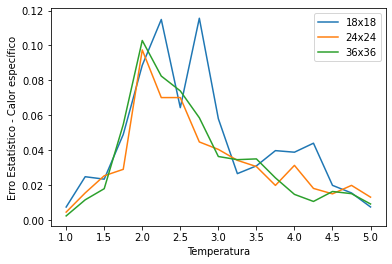

In [16]:
for r in redes: plt.plot(r.temps, r.cal_err)
plt.ylabel("Erro Estatístico - Calor específico")
plt.xlabel("Temperatura")
plt.legend(["18x18","24x24","36x36"])
plt.show()

É interessante perceber que a curva do calor específico é muito parecida com a gerada em atividades anteriores. Temos um pico ao redor da temperatura 2.5. Contudo, agora, é possível analisar também o erro estatístico, que também tem um pico ao redor dos 2.5.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Energia por Spin

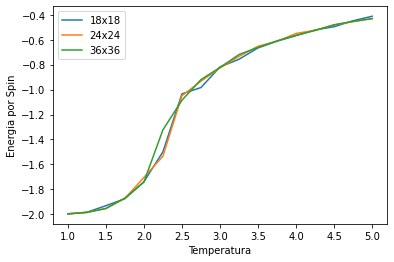

In [17]:
for r in redes: plt.plot(r.temps, r.ener)
plt.ylabel("Energia por Spin")
plt.xlabel("Temperatura")
plt.legend(["18x18","24x24","36x36"])
plt.show()

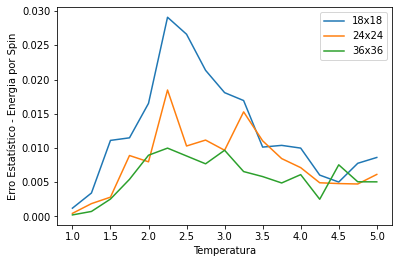

In [18]:
for r in redes: plt.plot(r.temps, r.ener_err)
plt.ylabel("Erro Estatístico - Energia por Spin")
plt.xlabel("Temperatura")
plt.legend(["18x18","24x24","36x36"])
plt.show()

A energia por spin também está igual aos resultados obtidos anteriormente. Começamos com valores baixos a baixas temperaturas e vamos rumo a valores próximos de zero. O erro é, no geral, pequeno se comparado com a ordem de grandeza da energia por spin. Ainda assim, temos um pico do erro da rede 18x18 ao redor dos 2.5. Ademais, tal como nas atividades anteriores, não é possível distinguir muito bem quais curvas de energia por spin estão acima e quais estão abaixo num dado momento, visto que todas estão concentradas.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Magnetização por Spin

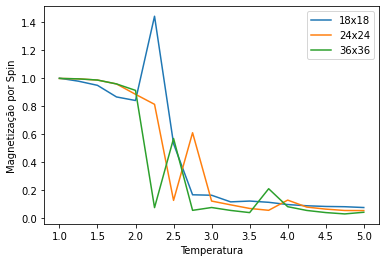

In [19]:
for r in redes: plt.plot(r.temps, r.mag)
plt.ylabel("Magnetização por Spin")
plt.xlabel("Temperatura")
plt.legend(["18x18","24x24","36x36"])
plt.show()

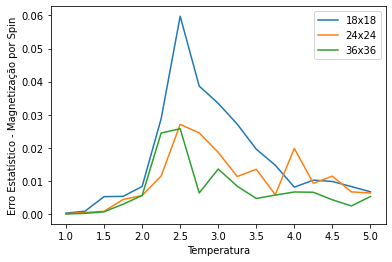

In [20]:
for r in redes: plt.plot(r.temps, r.mag_err)
plt.ylabel("Erro Estatístico - Magnetização por Spin")
plt.xlabel("Temperatura")
plt.legend(["18x18","24x24","36x36"])
plt.show()

Tendo como base os dados de magnetização média da atividade do Método de Wang-Landau, vemos que o comportamento global é semelhante aqui: a baixas temperaturas temos magnetização próxima de 1, ou seja, todos os sítios com a mesma direção; enquanto em altas temperaturas, a partir de 2.5, a magnetização tende a 0. Aqui nota-se uma influência grande do erro nas redes, sobretudo na 18x18, ao redor de 2.5. 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Susceptibilidade Magnética

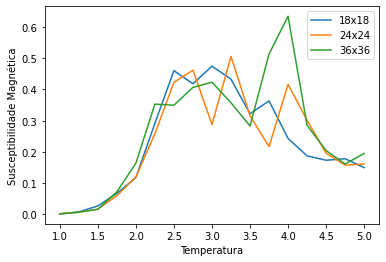

In [21]:
for r in redes: plt.plot(r.temps, r.sus)
plt.ylabel("Susceptibilidade Magnética")
plt.xlabel("Temperatura")
plt.legend(["18x18","24x24","36x36"])
plt.show()

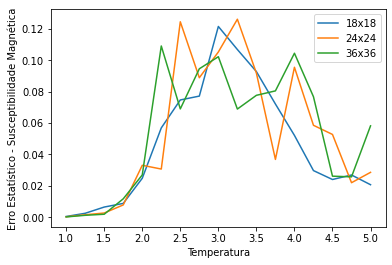

In [22]:
for r in redes: plt.plot(r.temps, r.sus_err)
plt.ylabel("Erro Estatístico - Susceptibilidade Magnética")
plt.xlabel("Temperatura")
plt.legend(["18x18","24x24","36x36"])
plt.show()

Especificamente nessa propriedade não temos como comparar com atividades anteriores, mas é possível notar que há um comportamento semelhante de todas as redes: parte-se de 0, tem-se uma subida até em torno do valor de 0.5, próximo da temperatura de 2.5, ficando-se ali até uma pequena queda ao final para cerca de 0.2 nas temperaturas mais altas. O erro acompanha esse comportamento, isto é, com maior susceptibilidade magnética, temos um erro estatístico maior.

### Discussão Geral

Com os resultados obtidos é possível notar comportamentos similares aos já obtidos em atividades anteriores. Talvez, devido tanto ao método utilizado quanto a uma amostragem em passos maiores de temperatura (aqui usamos $0.25$ enquanto em outras atividades chegou a se usar $0.01$), foram gerados gráficos mais "serrilhados". Apesar disso, como já ressaltado, foi possível aferir que o comportamento global é o mesmo, usando também como parâmetro os erros estatísticos.

Em temos de sistema, pode-se notar que a temperatura de 2.5 é emblemática, visto que em quase todas as análises ela serve de ponto de referência ou para alguma mudança de comportamento ou para ancorar uma característica notável. Além disso, é possível observar que em baixas temperaturas, o sistema tende à ordenação, ou seja, magnetização de módulo 1 (todos os spins com a mesma direção) e baixa energia (exatamente a $-2N$).